<original code : A 99 line topology optimization code written in Matlab O. Sigmund>  
Rewritten by soyoung yoo

 It.:    1                 Obj.:   435.8434 Vol.:  0.400                 ch.:  0.200
 It.:    2                 Obj.:   250.6173 Vol.:  0.400                 ch.:  0.200
 It.:    3                 Obj.:   178.4094 Vol.:  0.400                 ch.:  0.200
 It.:    4                 Obj.:   137.0343 Vol.:  0.400                 ch.:  0.200
 It.:    5                 Obj.:   118.9860 Vol.:  0.400                 ch.:  0.200
 It.:    6                 Obj.:   105.6184 Vol.:  0.400                 ch.:  0.200
 It.:    7                 Obj.:    95.9190 Vol.:  0.400                 ch.:  0.186
 It.:    8                 Obj.:    87.2625 Vol.:  0.400                 ch.:  0.173
 It.:    9                 Obj.:    81.5061 Vol.:  0.400                 ch.:  0.124
 It.:   10                 Obj.:    77.6441 Vol.:  0.400                 ch.:  0.132
 It.:   11                 Obj.:    74.5943 Vol.:  0.400                 ch.:  0.123
 It.:   12                 Obj.:    71.7875 Vol.:  0.400         

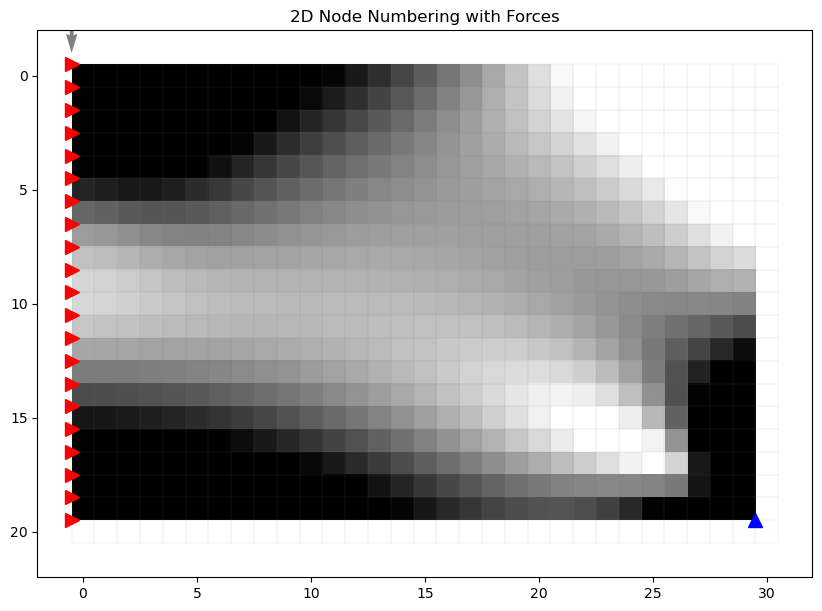

-1.0


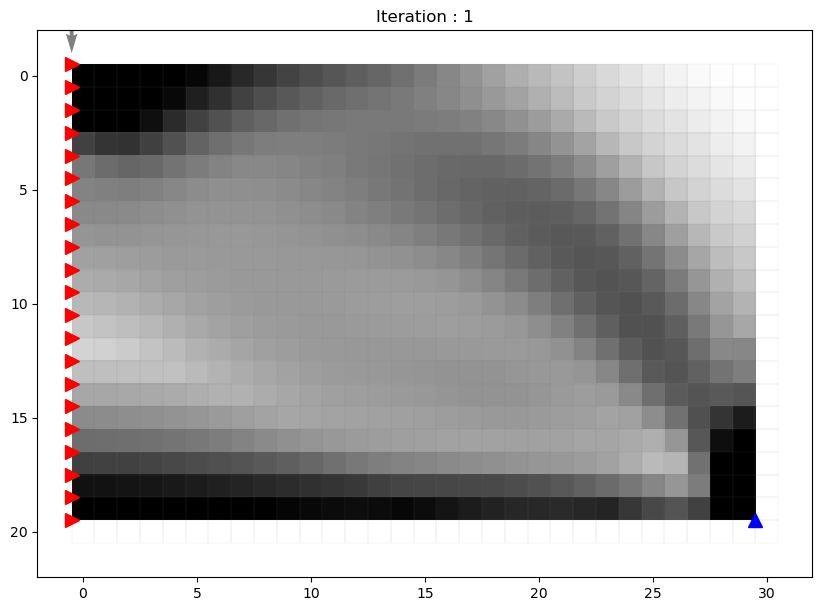

-1.0


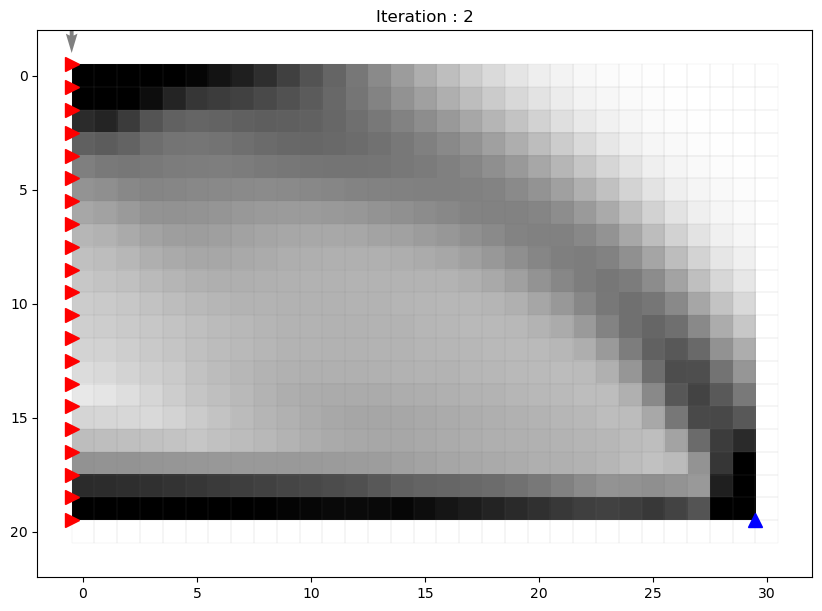

-1.0


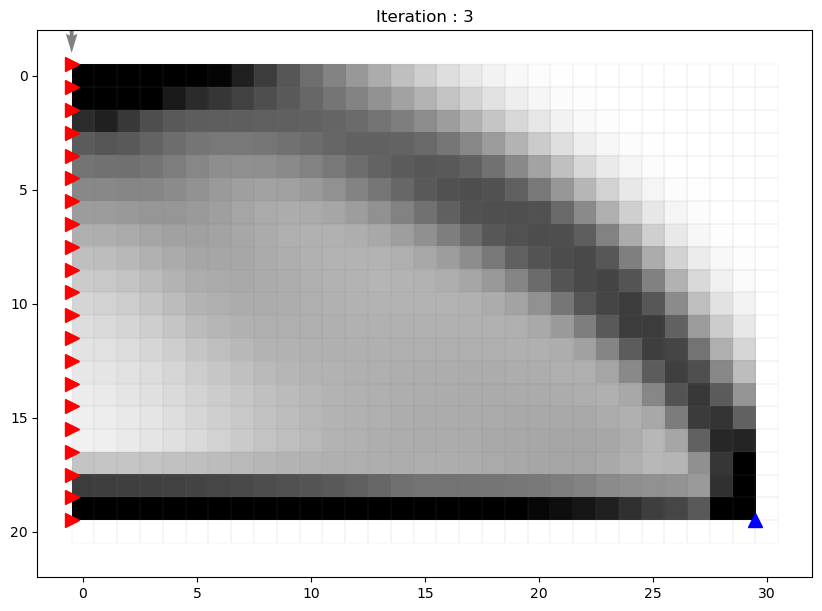

-1.0


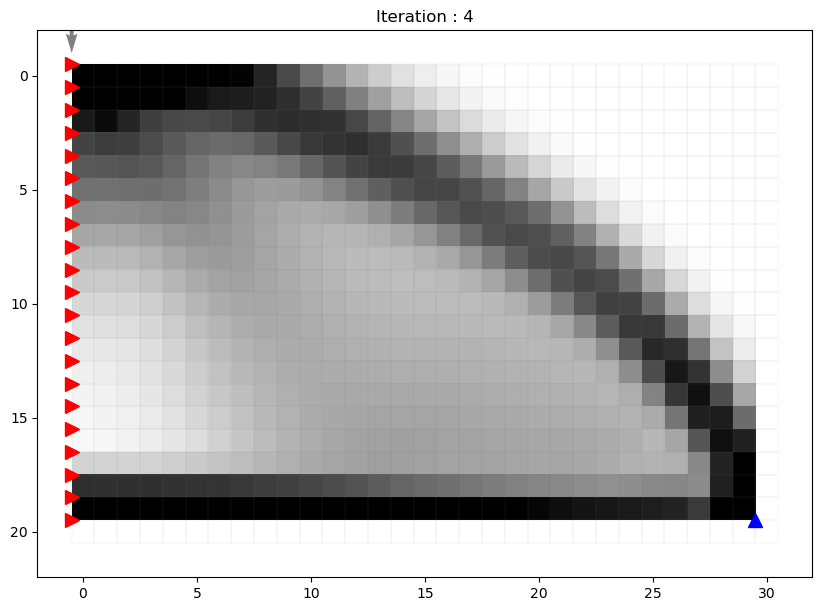

-1.0


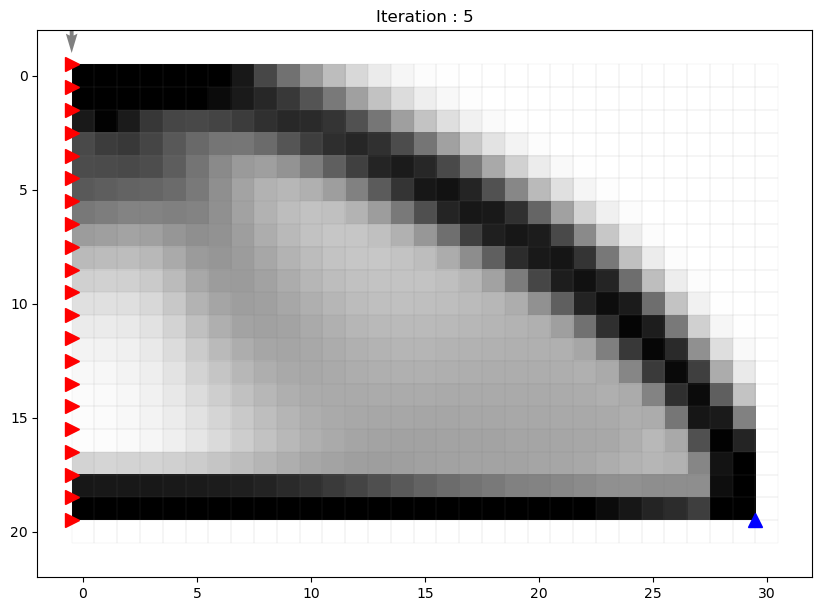

-1.0


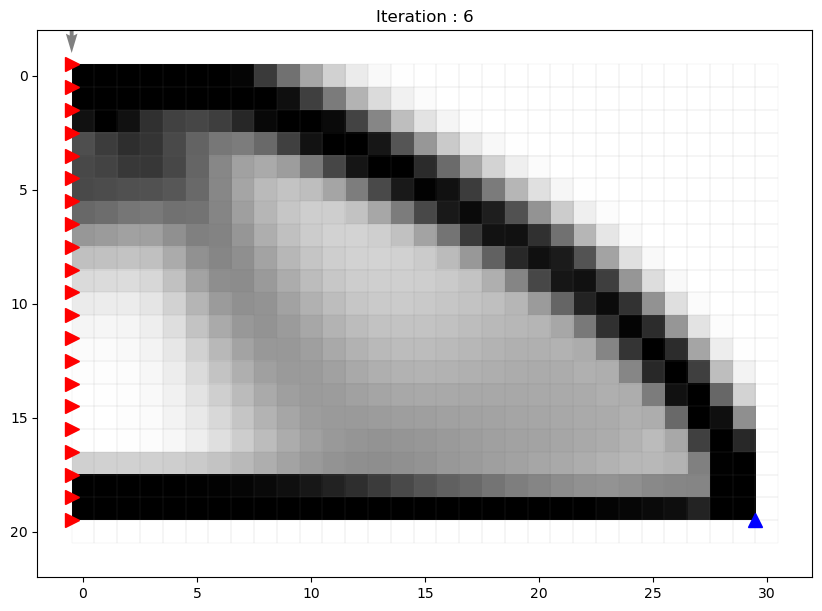

-1.0


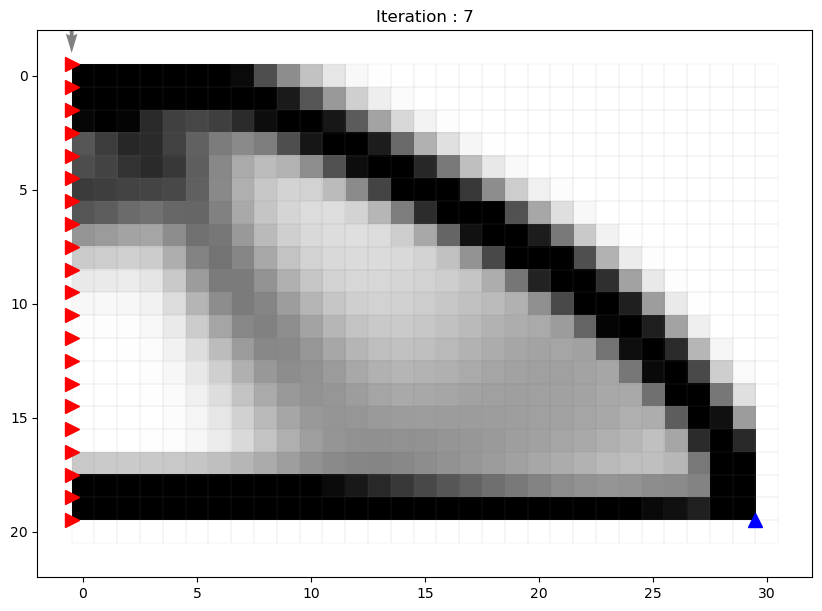

-1.0


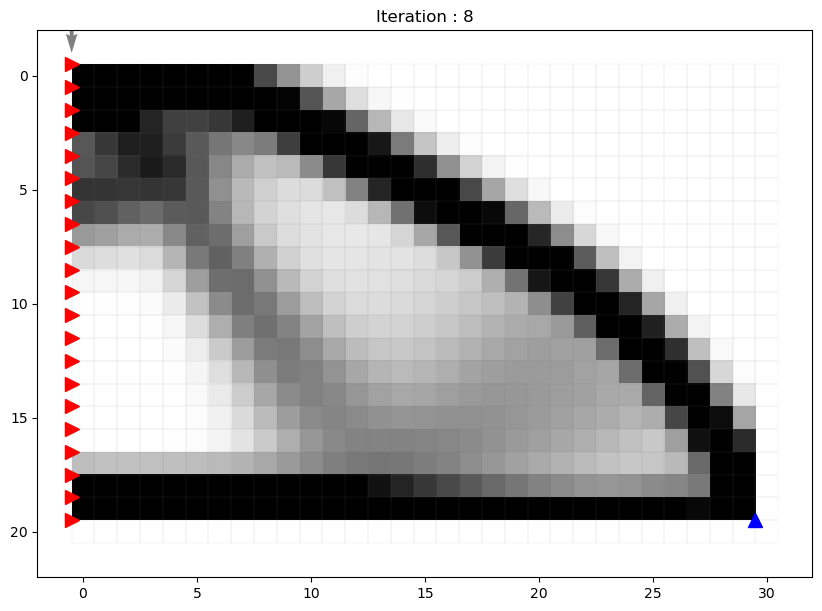

-1.0


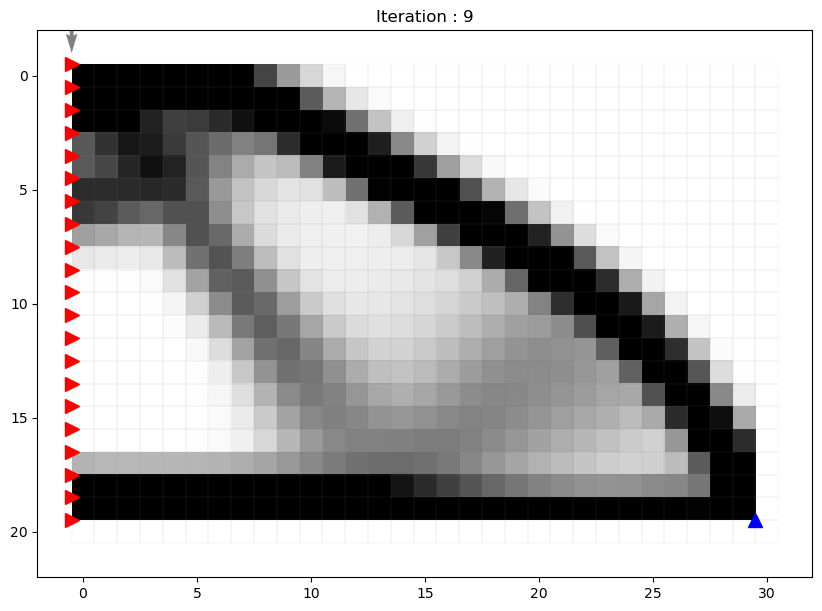

-1.0


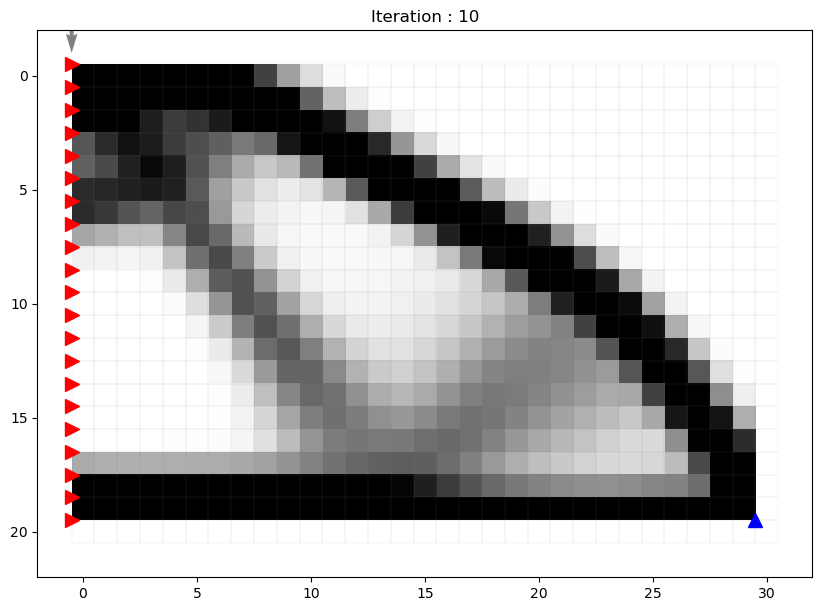

-1.0


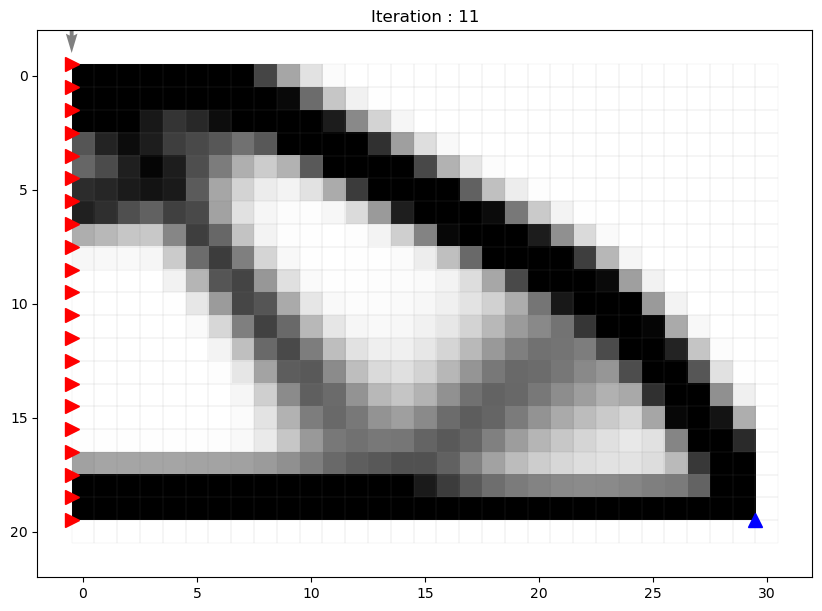

-1.0


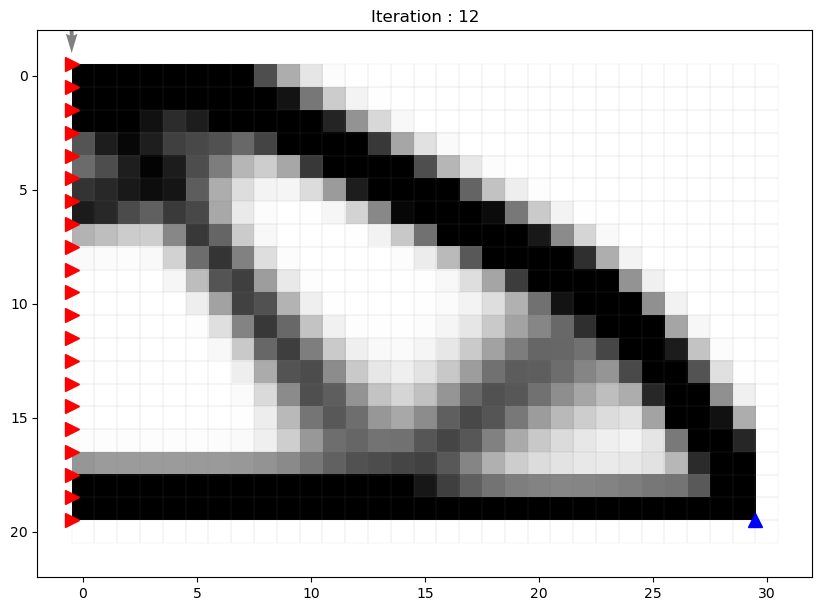

-1.0


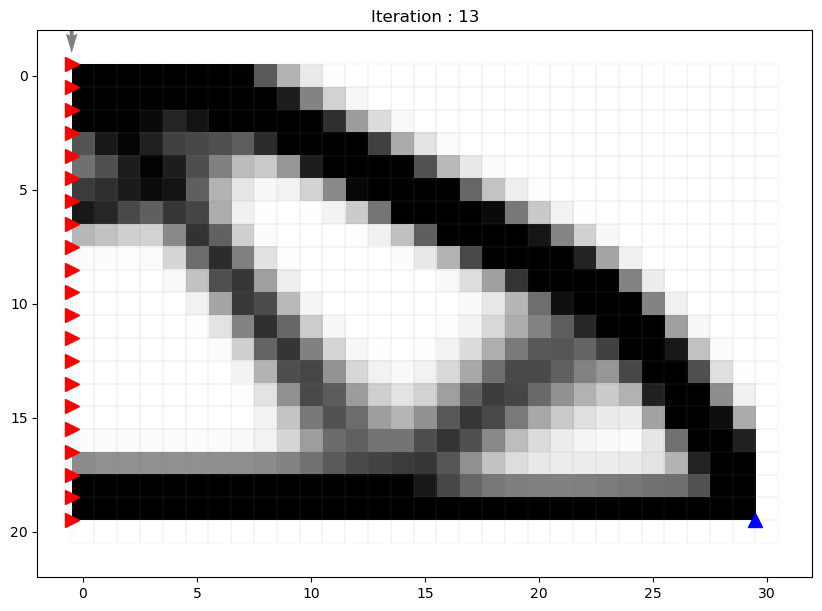

-1.0


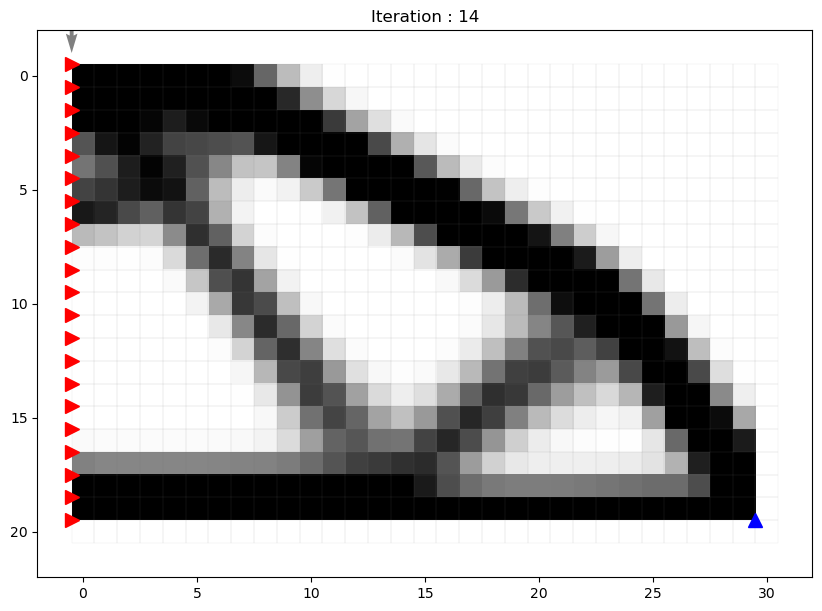

-1.0


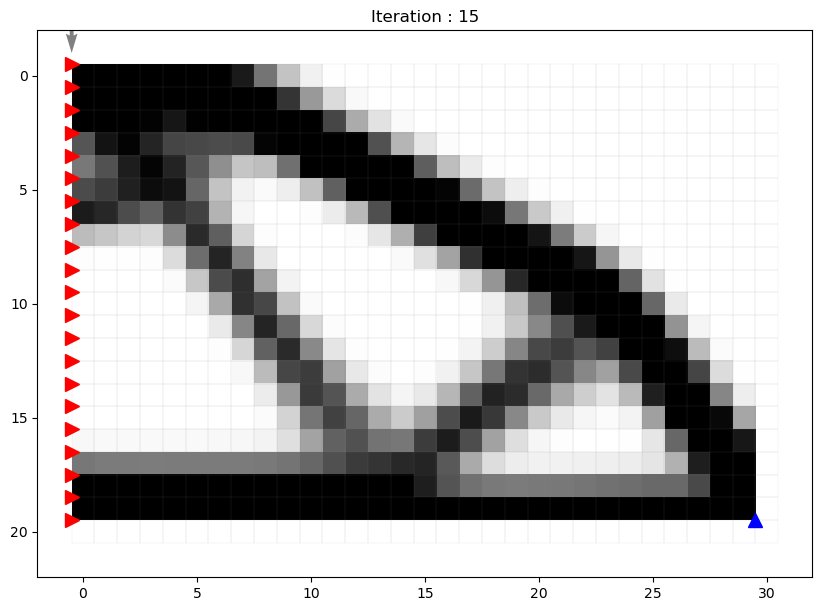

-1.0


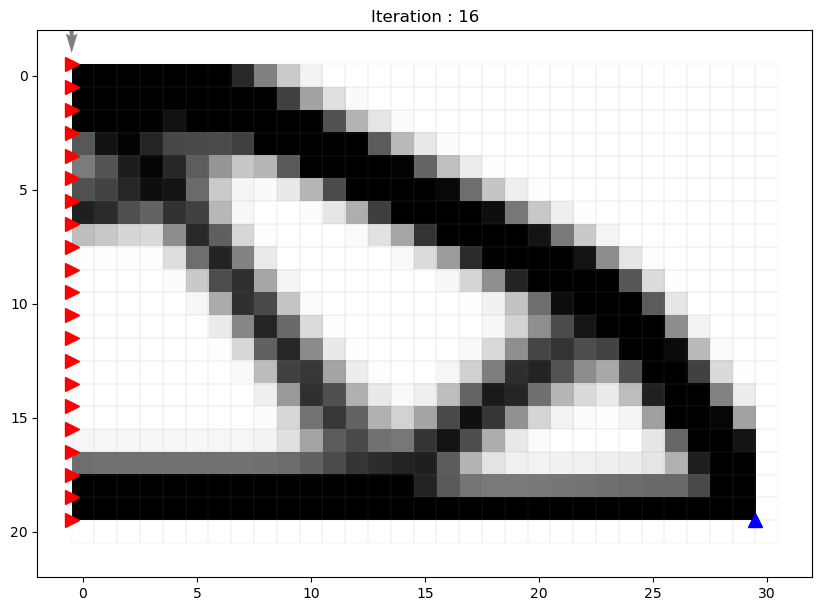

-1.0


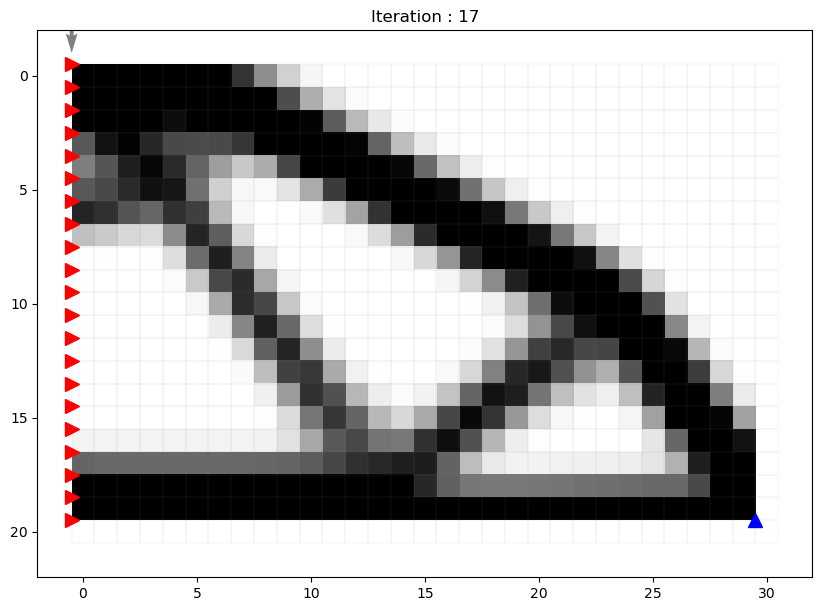

-1.0


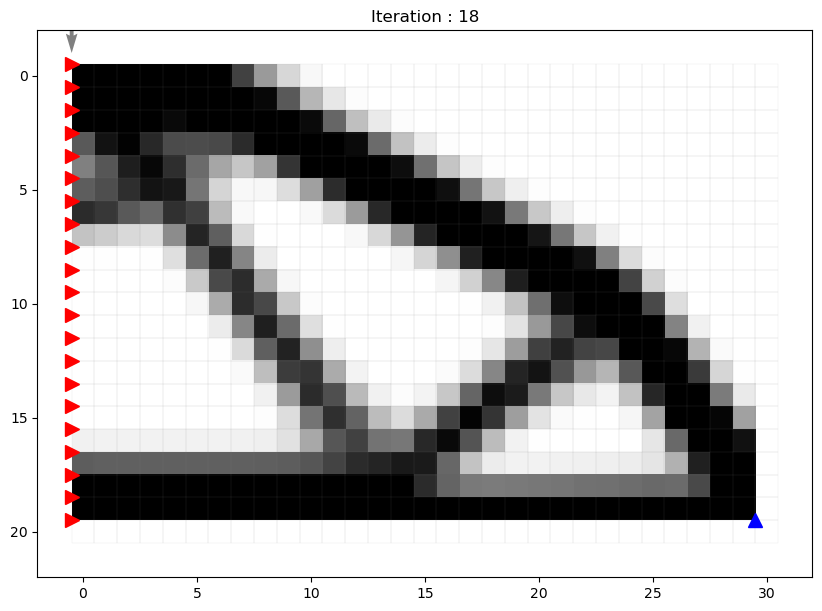

-1.0


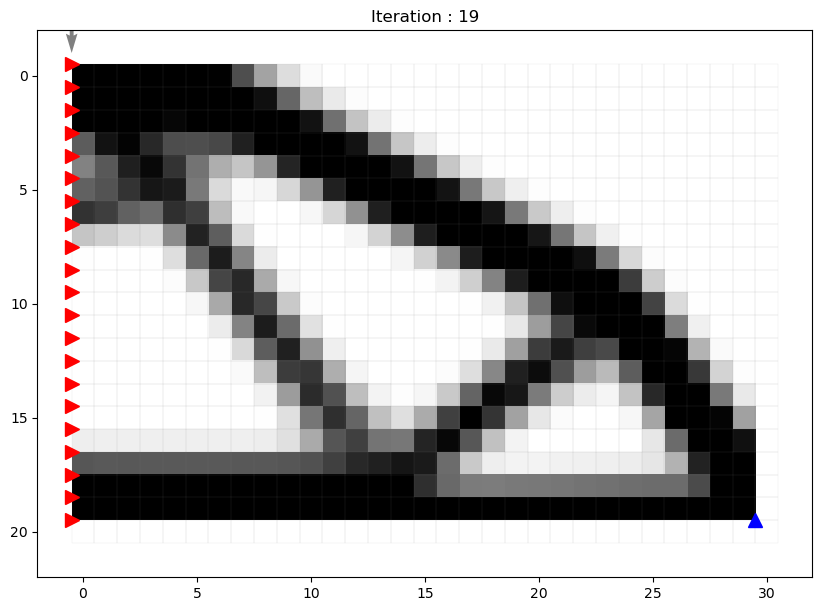

-1.0


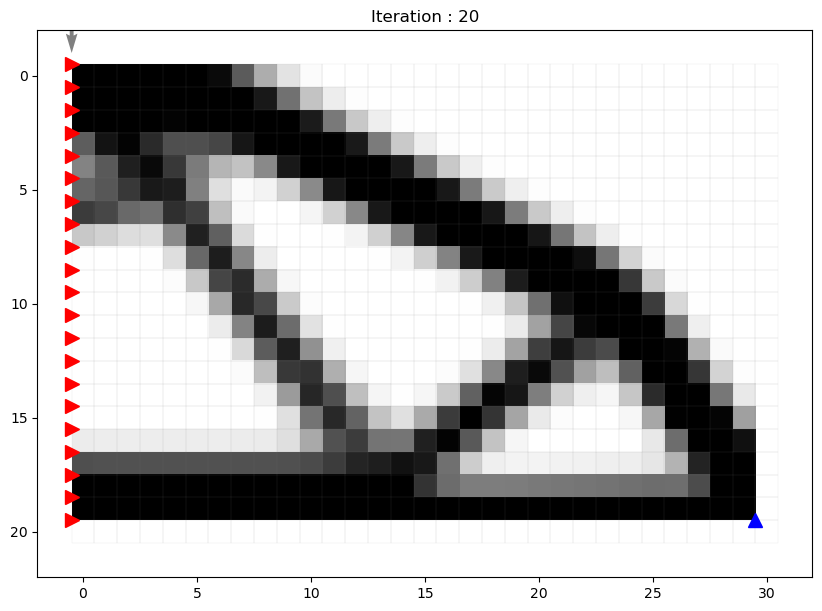

-1.0


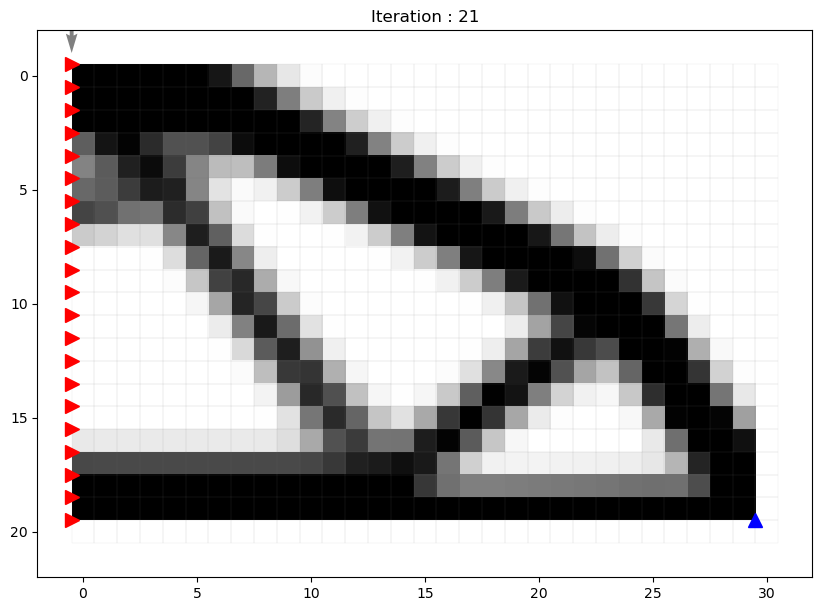

-1.0


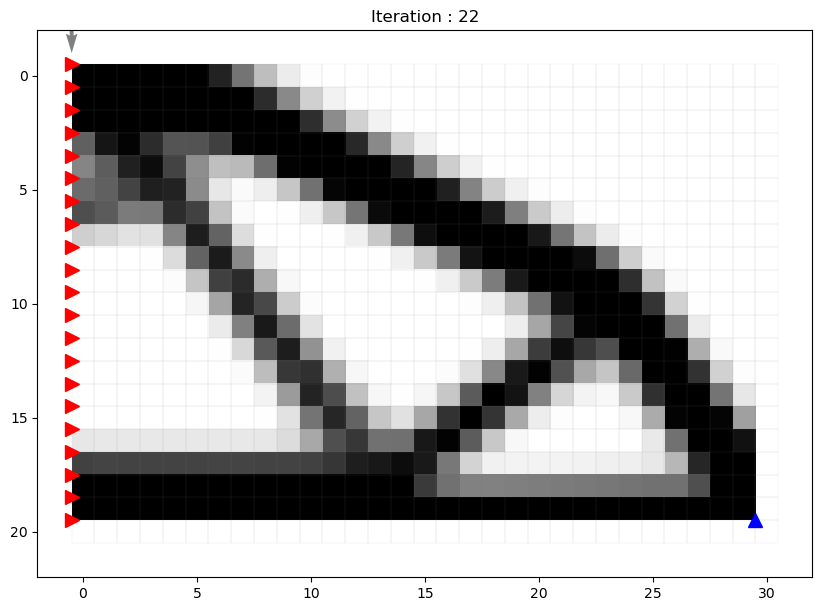

-1.0


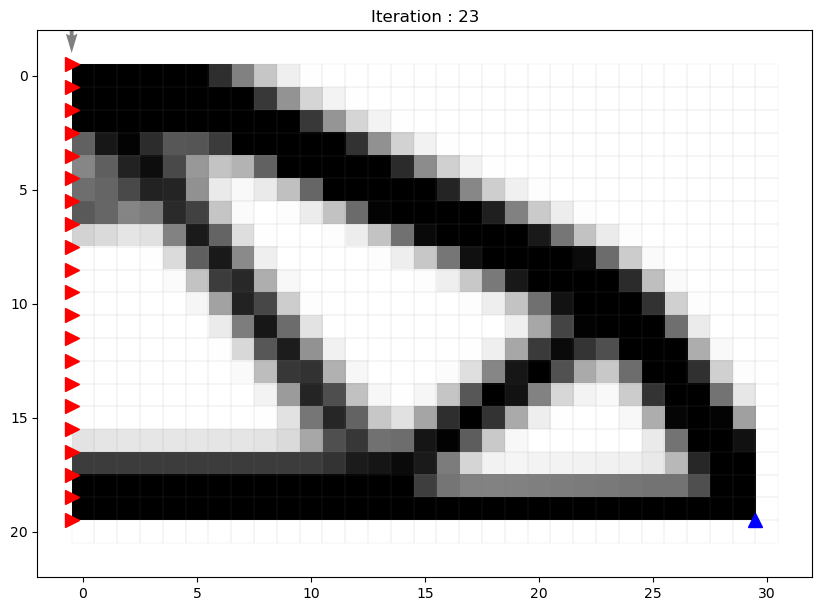

-1.0


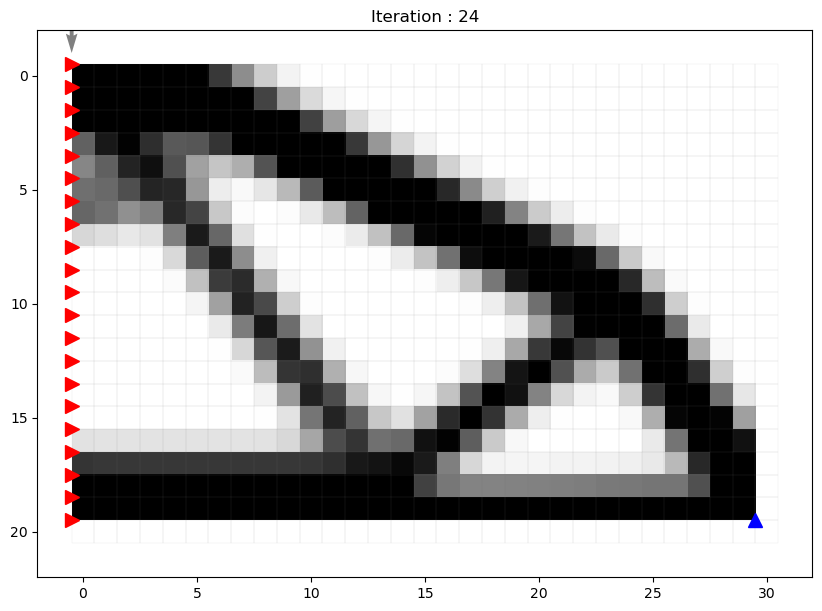

-1.0


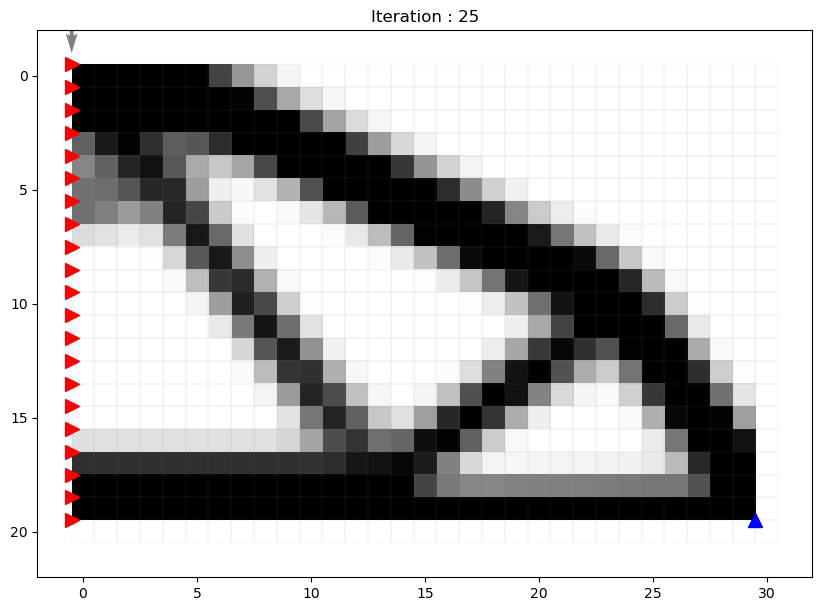

-1.0


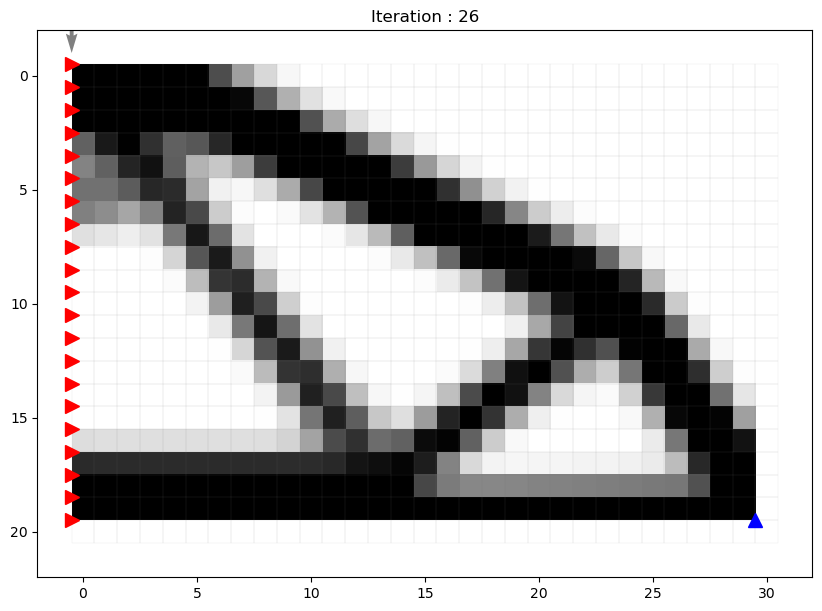

-1.0


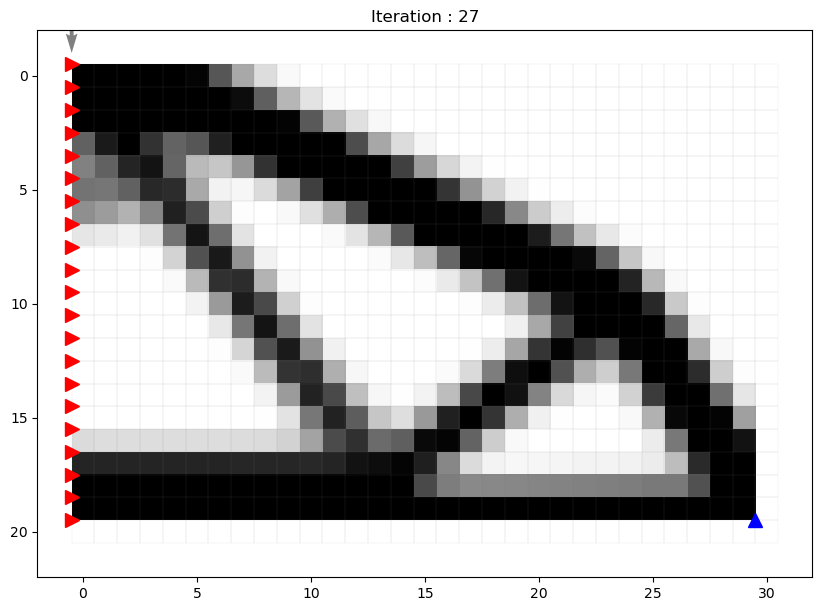

-1.0


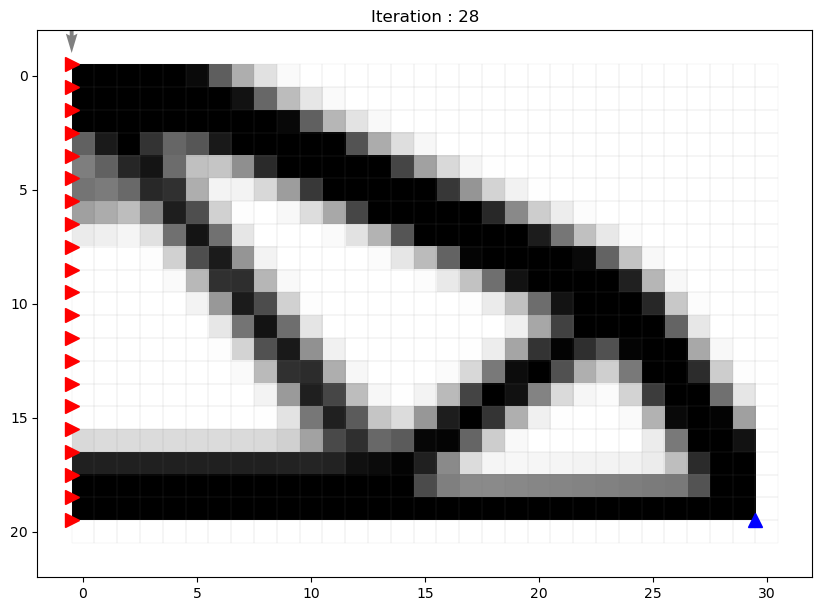

-1.0


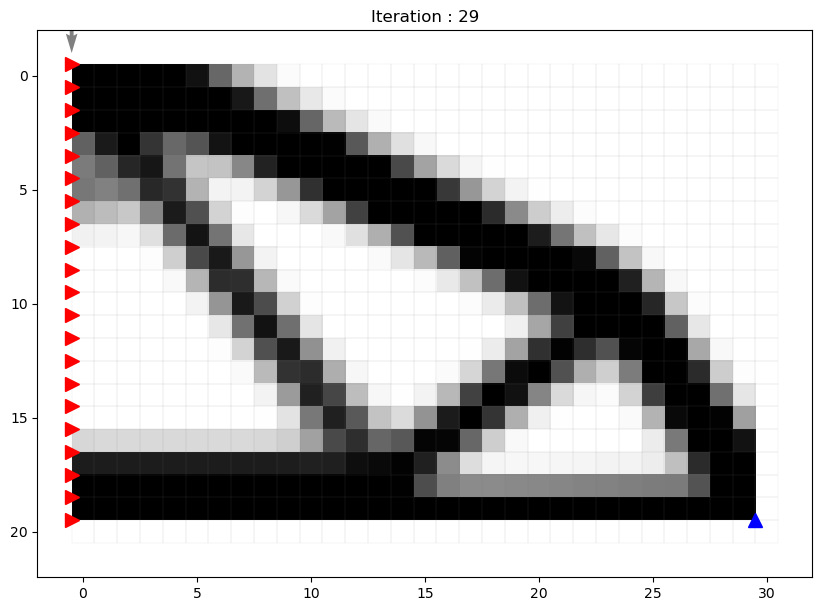

-1.0


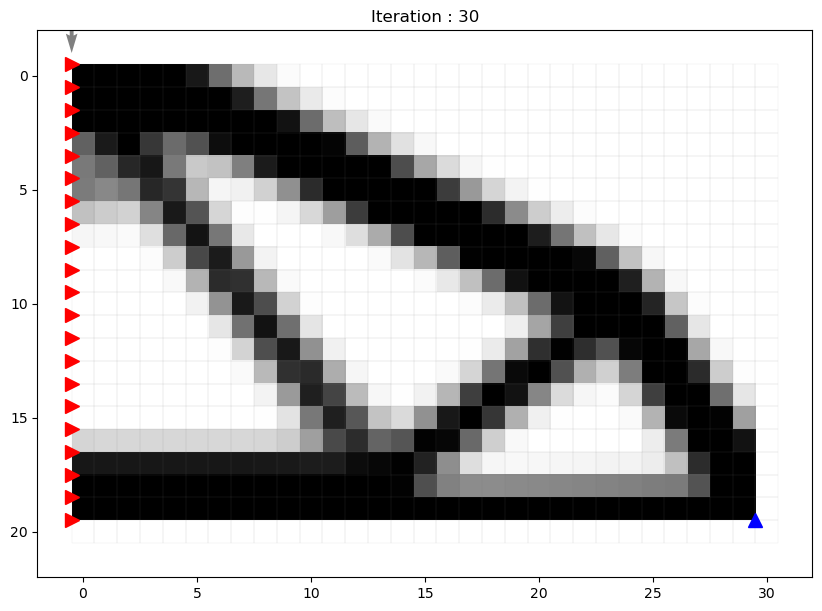

-1.0


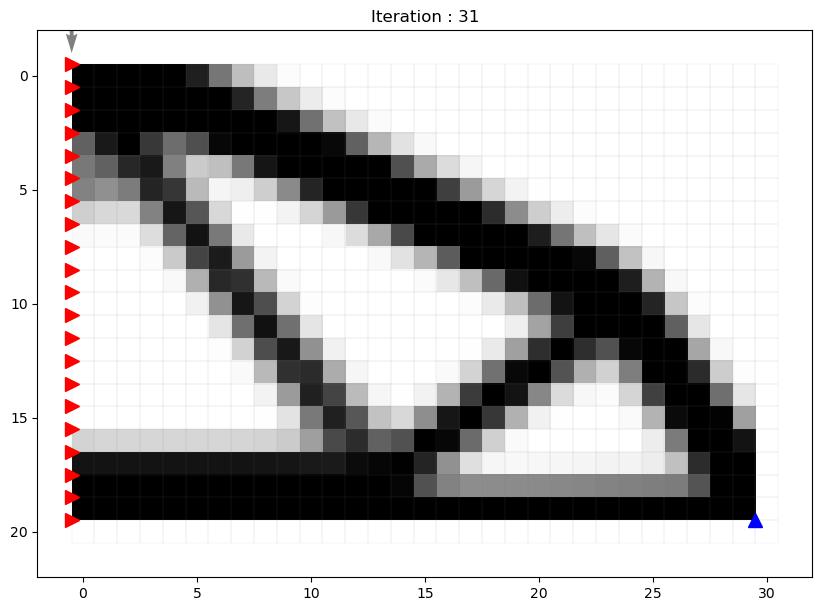

-1.0


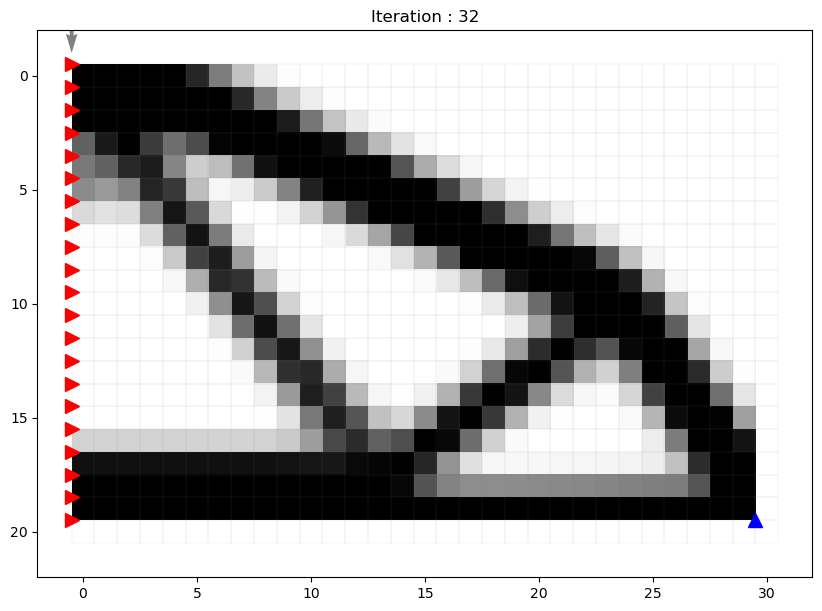

-1.0


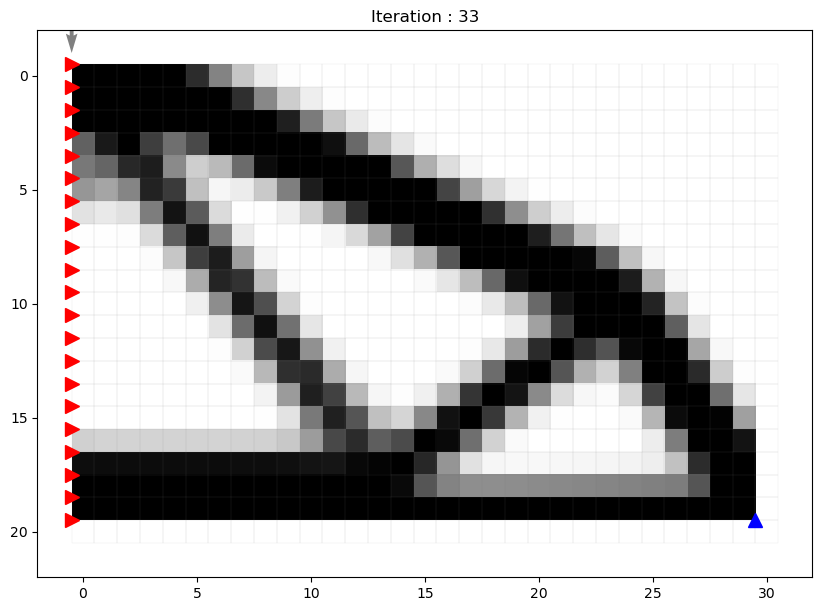

-1.0


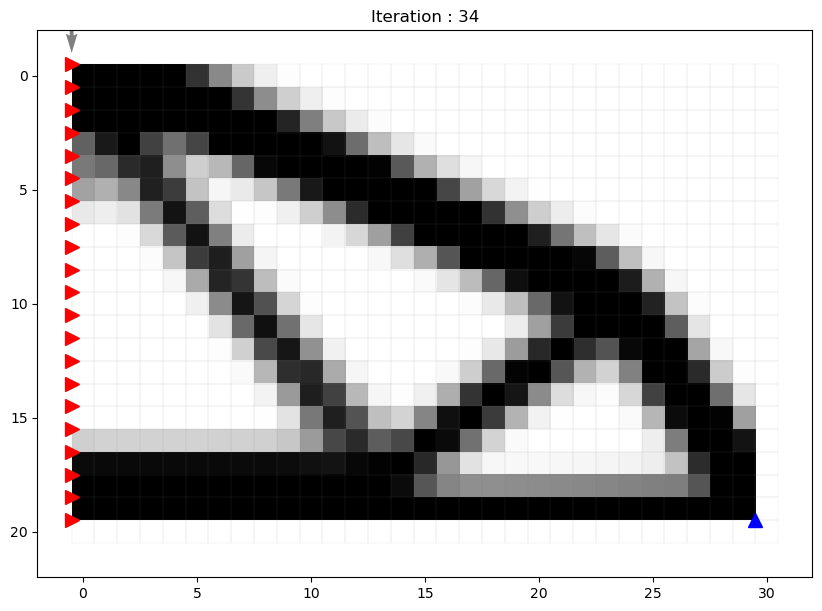

-1.0


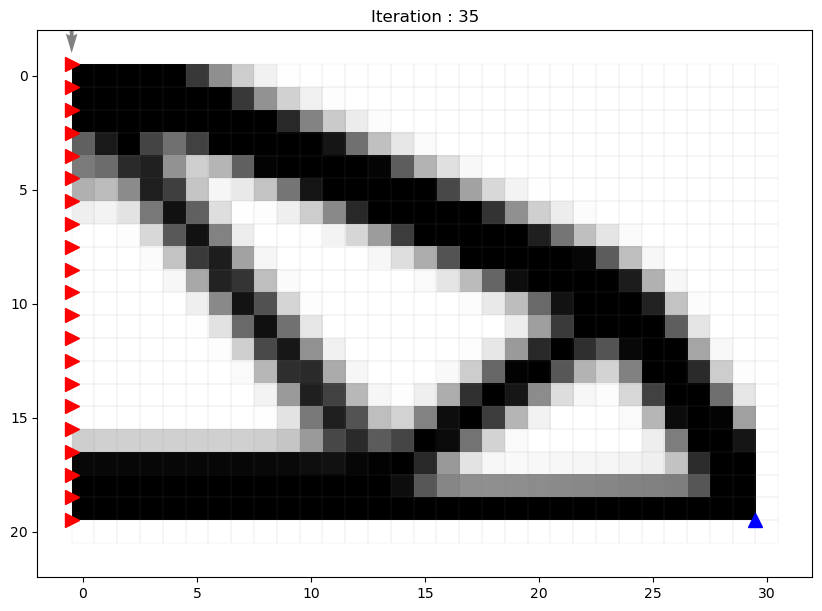

-1.0


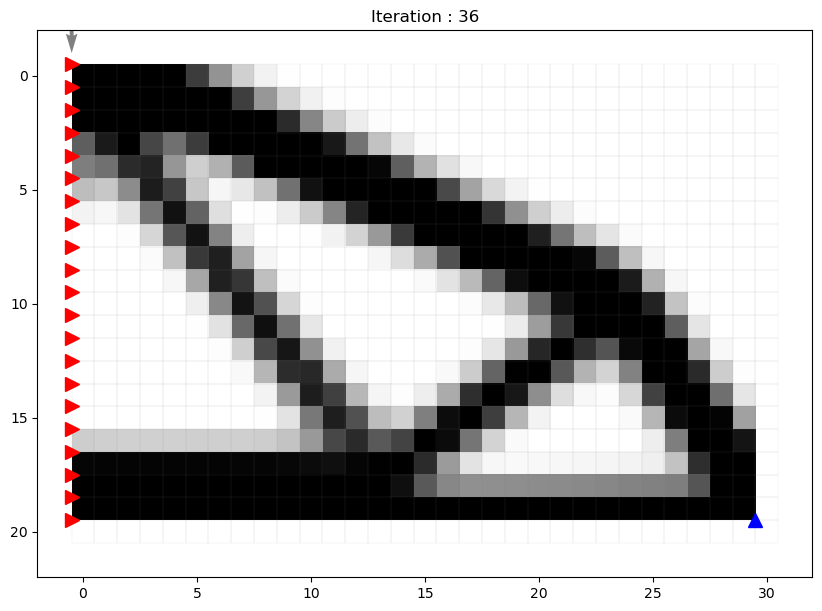

-1.0


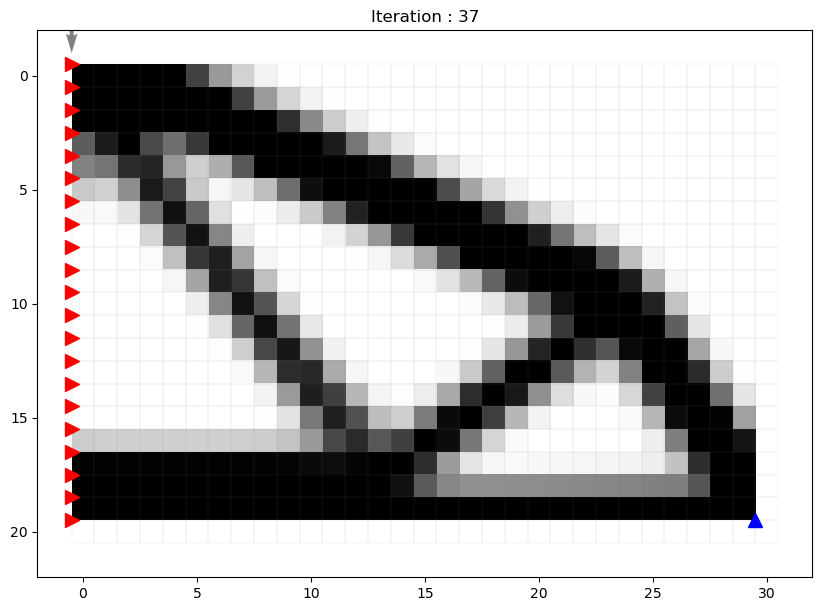

-1.0


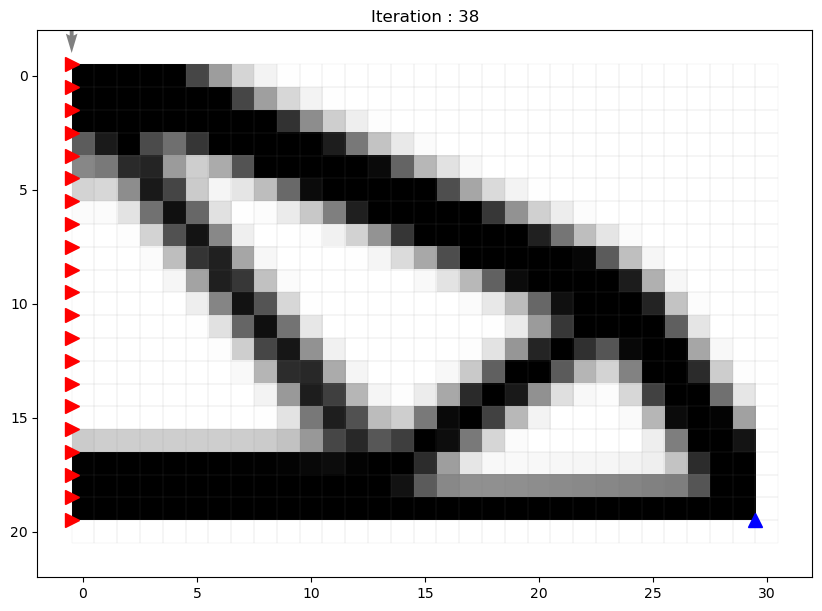

-1.0


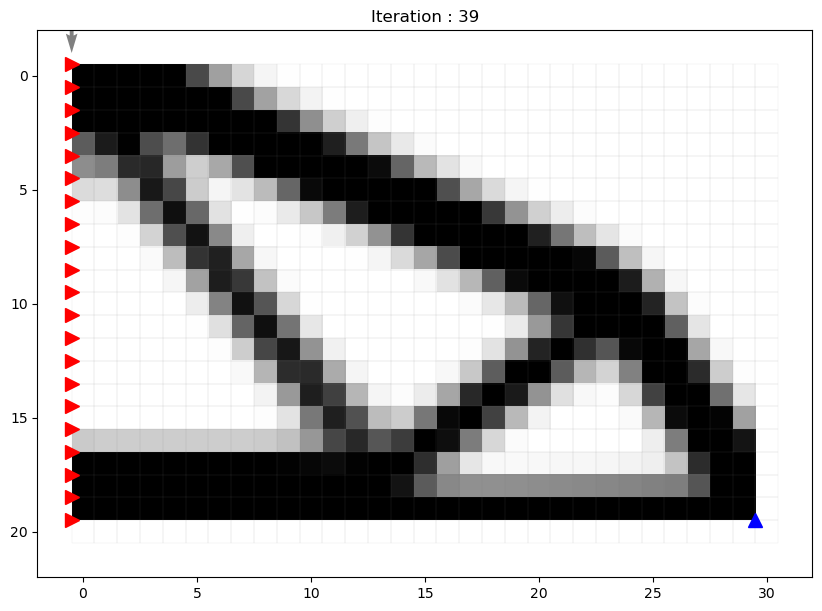

-1.0


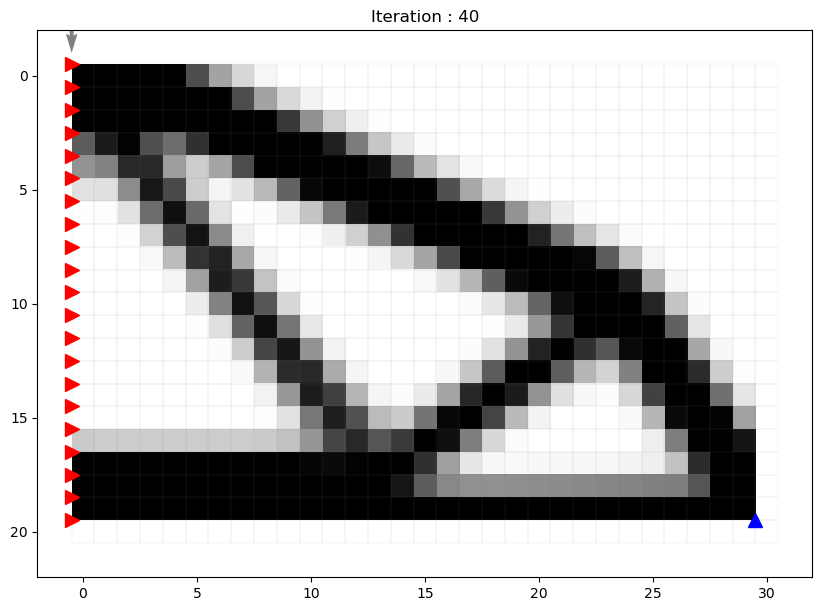

-1.0


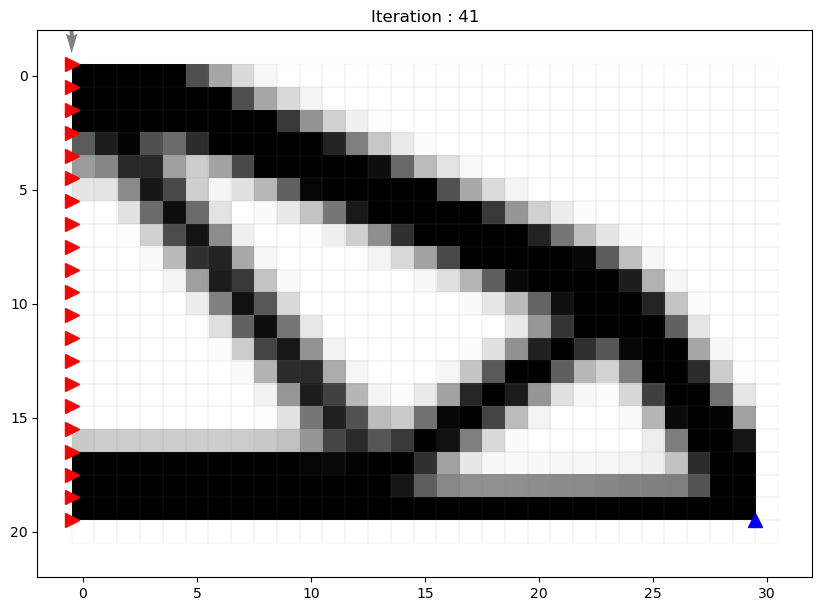

-1.0


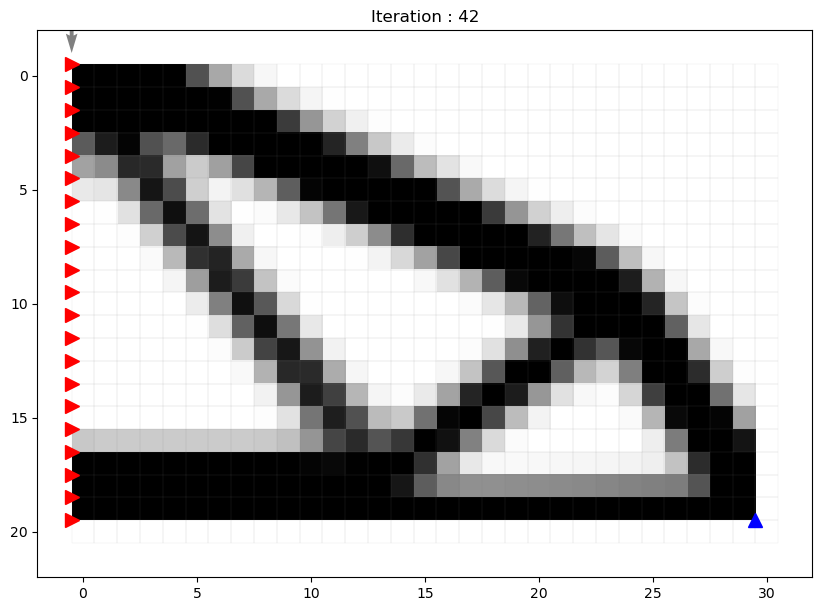

-1.0


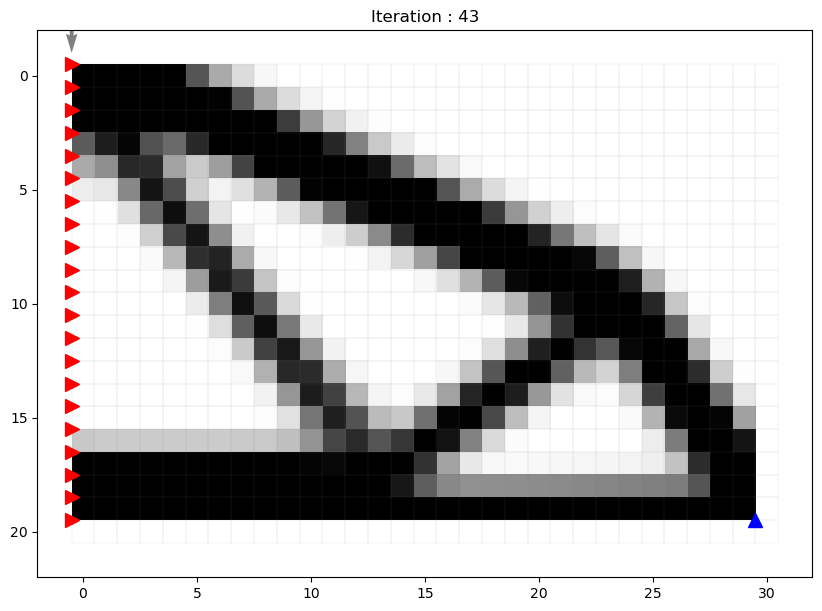

-1.0


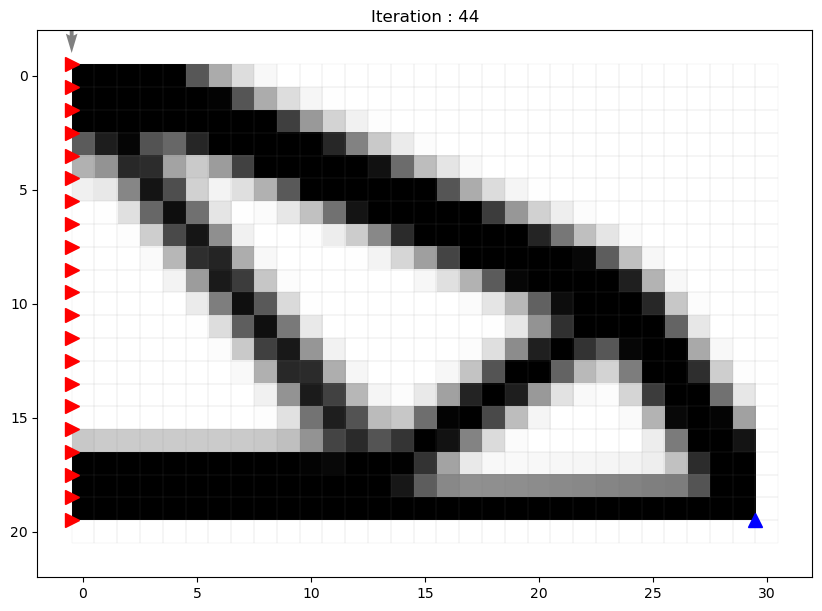

-1.0


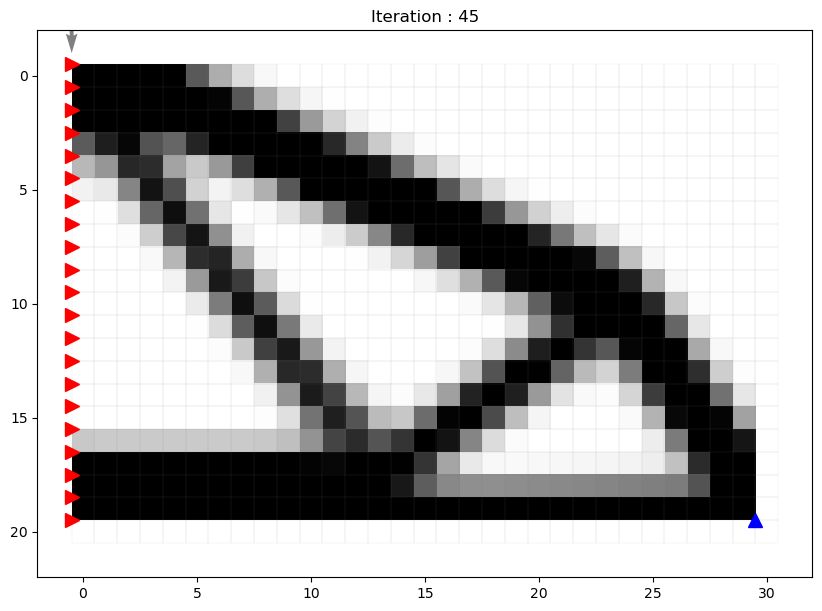

-1.0


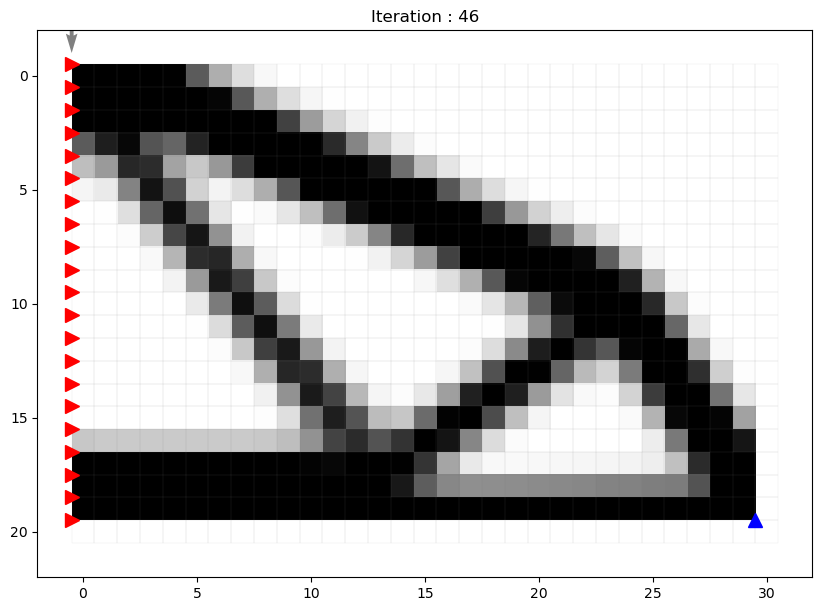

-1.0


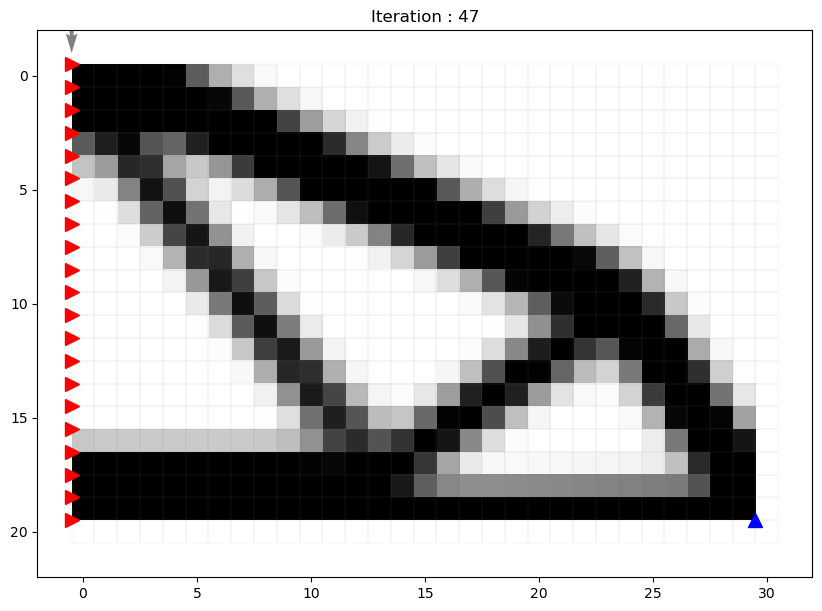

-1.0


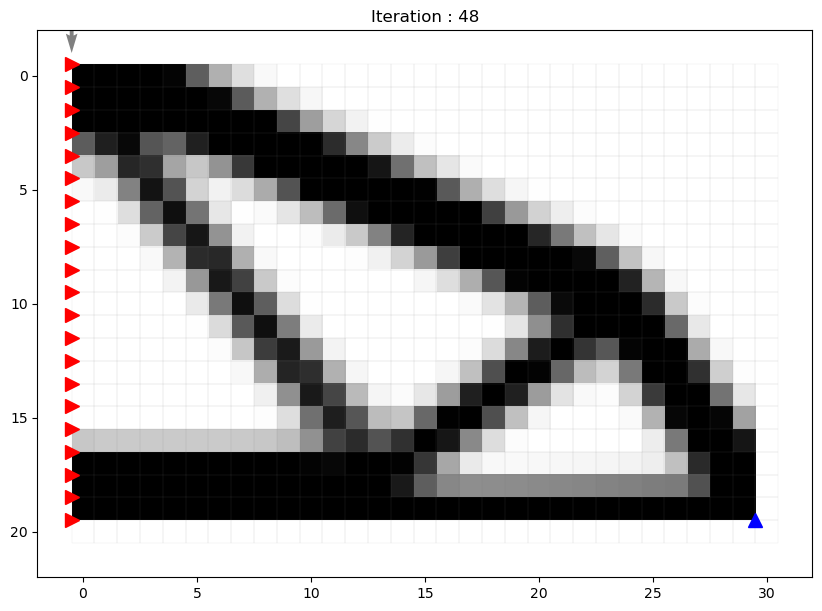

-1.0


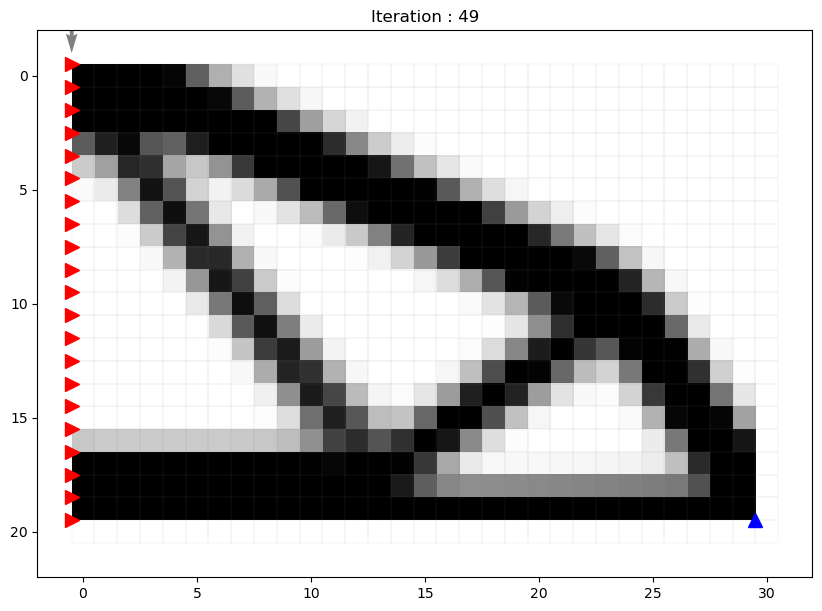

-1.0


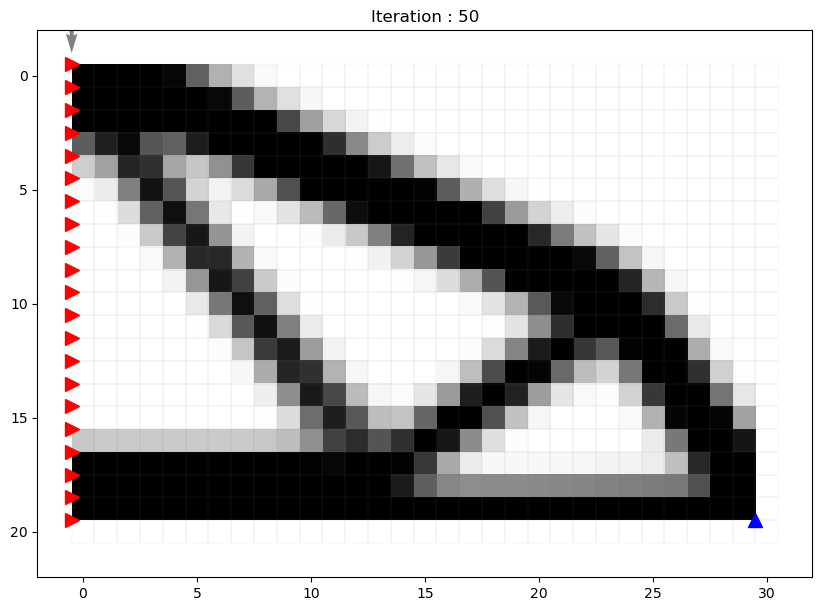

-1.0


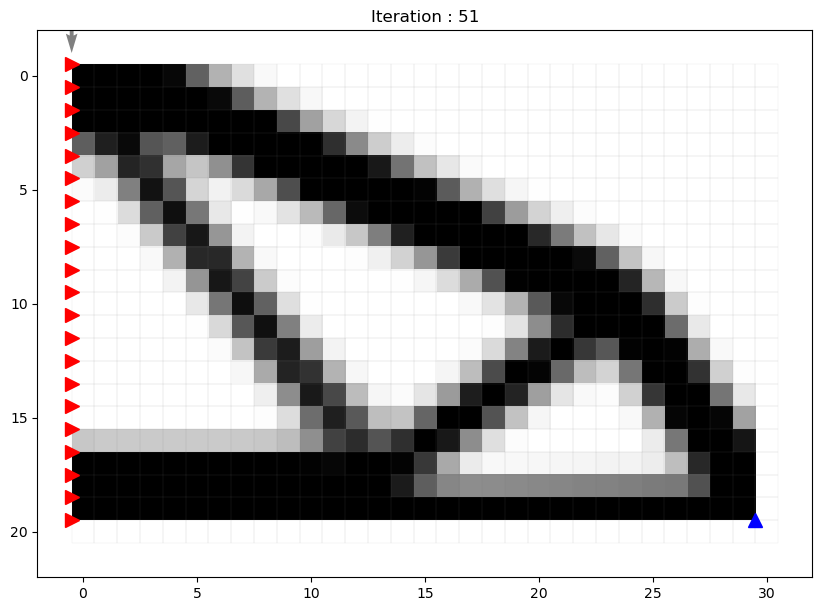

GIF saved as topology.gif


In [395]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# 함수: 밀도 배치를 시각화하는 함수
def vis(x,nelx,nely,F,fixeddofs,iteration_n=None):

    fig, ax = plt.subplots(figsize=(10, 8))

    # 하중이 적용된 노드 좌표 찾기
    F_x, F_y = np.where(F != 0)

    # 노드 번호 표시
    dof = 0
    for i in range(nelx + 1):
        i -=0.5
        for j in range(nely + 1):
            j -=0.5
            node_num = i * (nely + 1) + j
            dof_x, dof_y = 2 * dof, 2 * dof + 1
            rect = plt.Rectangle((i, j), 1, 1, fill=False, edgecolor='gray',linewidth=0.05)
            ax.add_patch(rect)

            # 고정된 자유도 시각화
            if dof_x in fixeddofs:
                plt.plot(i, j, color='red', marker='>', ms=10)
            elif dof_y in fixeddofs:
                plt.plot(i, j, color='blue', marker='^', ms=10)

            # 하중 시각화 (force visualization)
            if F[dof_x, 0] != 0:  # x축 방향 하중
                ax.quiver(i, j, -np.sign(F[dof_x, 0]), 0, angles='xy', scale_units='xy', scale=1, color='gray', width=0.005)

            if F[dof_y, 0] != 0:  # y축 방향 하중
                print(np.sign(F[dof_y, 0]))
                ax.quiver(i, j-1.5, 0, -np.sign(F[dof_y, 0]), angles='xy', scale_units='xy', scale=1, color='gray', width=0.005)

            # 노드 번호와 자유도 표시
            #ax.text(i, j, f'node #({str(node_num)})\n dof #({dof_x},{dof_y})',
            #        ha='right', va='bottom', fontsize=8, color='k')

            dof += 1

    plt.imshow(-x,cmap='gray')
    # 그래프 설정
    ax.set_xlim(-2, nelx + 2)
    ax.set_ylim(-2, nely + 2)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    if iteration_n:
        plt.title(f'Iteration : {iteration_n}')
    else:
        plt.title('2D Node Numbering with Forces')
    
    plt.show()
    
    return fig


# 함수: 토폴로지 최적화 과정 (메인 함수)
def top(nelx, nely, volfrac, penal, rmin):
    x = np.ones((nely, nelx)) * volfrac  # 재료 배치를 초기화, 모든 요소에 volfrac 비율로 재료 할당
    loop = 0  # 반복 횟수 초기화
    change = 1.0  # 변화율 초기화 (종료 조건을 위해 사용)
    x_history = []  # 각 반복마다의 밀도 배치를 저장할 리스트
    
    # 반복문: 변화율이 0.01 이하가 될 때까지 최적화 반복
    while change > 0.01:
        loop += 1  # 반복 횟수 증가
        xold = x.copy()  # 이전 재료 배치 기록
        
        # 유한 요소 해석 (FE-analysis)
        U,F, fixeddofs= FE(nelx, nely, x, penal)  # 각 요소의 변위를 계산
        
        # 목적 함수와 민감도 분석 (Objective function and sensitivity analysis)
        KE = lk()  # 요소 강성 행렬 생성
        c = 0.0  # 목적 함수 초기화
        dc = np.zeros((nely, nelx))  # 민감도 초기화
        
        # 모든 요소에 대해 목적 함수와 민감도 계산
        for ely in range(nely):
            for elx in range(nelx):
                n1 = (nely+1)*(elx) + ely  # 첫 번째 노드 번호 계산
                n2 = (nely+1)*(elx+1) + ely  # 두 번째 노드 번호 계산
                Ue = U[[2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n2+2, 2*n2+3, 2*n1+2, 2*n1+3], 0]  # 각 요소의 변위 벡터
                c += (x[ely, elx] ** penal) * np.dot(Ue.T, KE @ Ue)  # 목적 함수 값 업데이트
                dc[ely, elx] = -penal * (x[ely, elx] ** (penal-1)) * np.dot(Ue.T, KE @ Ue)  # 민감도 계산
        
        # 민감도 필터링 (Filtering of sensitivities)
        dc = check(nelx, nely, rmin, x, dc)  # 민감도 값을 부드럽게 만들어 필터링
        
        # 최적화 기준 방법으로 재료 배치 업데이트 (Design update by the optimality criteria method)
        x = OC(nelx, nely, x, volfrac, dc)  # 민감도와 볼륨 조건을 기반으로 재료 배치를 업데이트
        
        # 결과 출력 (Print results)
        change = np.max(np.abs(x - xold))  # 변화율 계산 (이전 배치와 현재 배치의 차이)
        print(f" It.: {loop:4d} \
                Obj.: {c:10.4f} Vol.: {np.sum(x)/(nelx*nely):6.3f} \
                ch.: {change:6.3f}")  # 현재 상태 출력
        
        # 각 반복마다 밀도 배치를 저장 (반복 후 전체 결과를 기록)
        x_history.append(x)
        #fig = vis(x,nelx,nely,F,fixeddofs)
        
    return x_history  # 반복마다의 밀도 배치를 반환

# 함수: 유한 요소 해석 (FE-analysis)
def FE(nelx, nely, x, penal):
    KE = lk()  # 요소 강성 행렬 생성
    K = lil_matrix((2 * (nelx + 1) * (nely + 1), 2 * (nelx + 1) * (nely + 1)))  # 전체 시스템 강성 행렬 초기화 (희소 행렬)
    F = np.zeros((2 * (nely + 1) * (nelx + 1), 1))  # 하중 벡터 초기화
    U = np.zeros((2 * (nely + 1) * (nelx + 1), 1))  # 변위 벡터 초기화
    
    # 각 요소에 대한 강성 행렬을 조립
    for ely in range(nely):
        for elx in range(nelx):
            n1 = (nely+1)*(elx) + ely  # 첫 번째 노드 번호 계산
            n2 = (nely+1)*(elx+1) + ely  # 두 번째 노드 번호 계산
            edof = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n2+2, 2*n2+3, 2*n1+2, 2*n1+3])  # 요소의 자유도 배열
            K[np.ix_(edof, edof)] += x[ely, elx] ** penal * KE  # 요소 강성 행렬을 시스템 강성 행렬에 추가
    
    # 하중과 경계 조건 설정 (Define loads and supports)
    F[1] = -1  # 첫 번째 노드에 하중 적용
    fixeddofs = np.union1d(np.arange(0, 2 * (nely+1), 2), np.array([2 * (nelx + 1) * (nely + 1) - 1]))  # 고정된 자유도 설정
    alldofs = np.arange(2 * (nely + 1) * (nelx + 1))  # 전체 자유도
    freedofs = np.setdiff1d(alldofs, fixeddofs)  # 고정된 자유도를 제외한 자유도 계산
    
    # 방정식 풀이 (Solving)
    U[freedofs, 0] = spsolve(K[freedofs, :][:, freedofs], F[freedofs, 0])  # 시스템 방정식을 풀어 변위 계산
    U[fixeddofs] = 0  # 고정된 자유도는 변위 0으로 설정
    
    return U, F, fixeddofs  # 변위 반환

# 함수: 최적화 기준(Optimality Criteria) 업데이트 함수
def OC(nelx, nely, x, volfrac, dc):
    l1 = 0  # 하한 값
    l2 = 100000  # 상한 값
    move = 0.2  # 재료 배치를 업데이트할 수 있는 최대 이동량
    
    # 이분법을 사용하여 최적화 반복
    while (l2 - l1) > 1e-4:
        lmid = 0.5 * (l2 + l1)  # 중간값 계산
        xnew = np.maximum(0.001, np.maximum(x - move, np.minimum(1.0, np.minimum(x + move, x * np.sqrt(-dc / lmid)))))  # 재료 배치 업데이트
        if np.sum(xnew) - volfrac * nelx * nely > 0:  # 재료 사용량이 제한을 초과할 경우
            l1 = lmid  # 하한 값을 중간값으로 이동
        else:
            l2 = lmid  # 상한 값을 중간값으로 이동
    
    return xnew  # 업데이트된 재료 배치 반환

# 함수: 민감도 필터링 (Sensitivity filtering)
def check(nelx, nely, rmin, x, dc):
    dcn = np.zeros((nely, nelx))  # 필터링된 민감도 초기화
    
    # 필터링 반경 rmin을 기준으로 민감도 값 필터링
    for i in range(nelx):
        for j in range(nely):
            sum_val = 0.0  # 합계 초기화
            for k in range(max(i - round(rmin), 0), min(i + round(rmin), nelx)):  # 필터링 범위 내에서 계산
                for l in range(max(j - round(rmin), 0), min(j + round(rmin), nely)):
                    fac = rmin - np.sqrt((i - k) ** 2 + (j - l) ** 2)  # 거리 기반 필터링 계수
                    sum_val += max(0, fac)  # 필터링 계수의 합계
                    dcn[j, i] += max(0, fac) * x[l, k] * dc[l, k]  # 필터링된 민감도 계산
            dcn[j, i] /= (x[j, i] * sum_val)  # 필터링 값 적용
    
    return dcn  # 필터링된 민감도 반환

# 함수: 요소 강성 행렬 생성
def lk():
    E = 1.0  # 재료의 탄성 계수
    nu = 0.3  # 포아송 비율
    k = np.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,  # 강성 행렬을 구성하는 값들
                  -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    
    # 요소 강성 행렬 계산
    KE = E / (1 - nu**2) * np.array([
        [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
        [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
        [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
        [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
        [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
        [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
        [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
        [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]
    ])
    return KE  # 요소 강성 행렬 반환
nelx, nely, volfrac, penal, rmin = 30, 20, 0.4, 3, 1.5
x_history = top(nelx, nely, volfrac, penal, rmin)
U, F, fixeddofs = FE(nelx, nely, x_history[-1], penal)


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io

def create_figure(frame):
    fig, ax = plt.subplots(figsize=(8, 6))
    x = np.linspace(0, 10, 100)
    y = np.sin(x + frame / 10)
    ax.plot(x, y)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(f'Frame {frame}')
    return fig

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
    buf.seek(0)
    img = Image.open(buf)
    return img

# 프레임 생성
frames = []
num_frames = 50

for i, img in enumerate(x_history):
    fig = vis(img,nelx, nely, F, fixeddofs, iteration_n =i)
    img = fig2img(fig)
    frames.append(img)
    plt.close(fig)  # 메모리 절약을 위해 figure 닫기

# 첫 번째 이미지를 기준으로 GIF 생성
duration = 100  # 각 프레임 지속 시간 (밀리초)
gif_name = 'topology.gif'

if frames:
    frames[0].save(
        gif_name,
        save_all=True,
        append_images=frames[1:], 
        duration=duration,
        loop=0
    )
    print(f"GIF saved as {gif_name}")
else:
    print("No frames to create GIF")